#**Sentiment Analysis**


*   Sentiment Analysis interprets emotion expressed in a text. 

*   Sentiment analysis is used to determine whether a given text contains negative, positive, or neutral emotions.
*   It is commonly used to analyze product reviews, customer feedback,and survey responses. 
*   It can benifitted for Social media monitoring, reputation management, and customer experience.
*   It’s a form of text analytics that uses natural language processing (NLP) and machine learning. 


# Installation and import of modules

In [1]:
# Installing all dependencies:

# For Language detection module:
!pip install langdetect

# For word cloud:
!pip install wordcloud

# For preprocessing
!pip install lxml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 5.3 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993241 sha256=15385645c1a98a7e4c448115de10bdb86ff895d17b6c0a0ca673ff7eb207b851
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes = True)
%matplotlib inline
from langdetect import detect
from wordcloud import WordCloud

import nltk
from bs4 import BeautifulSoup
import re
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score , classification_report , confusion_matrix
import pickle
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Connect to Google collab and set Folder and File Paths

In [3]:
# Coonect to google collab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
# Folder paths for Google Collab
project_folder_path = "/content/gdrive/MyDrive/AIML/Labs/SentimentAnalysis/"
data_file_path_train = project_folder_path + "Train.csv"
data_file_path_test = project_folder_path + "Test.csv"
data_file_path_valid = project_folder_path + "Valid.csv"
# Folder paths to save the pickled model and vectorizer
tfidf_file_path = project_folder_path + "tfidf_vectorizer_1000.pkl"
model_mnb_file_path = project_folder_path + "model_mnb.pkl"
model_xgbhp_file_path = project_folder_path + "model_xgbhp.pkl"
cv_file_path = project_folder_path + "count_vectorizer_unibigram.pkl"
model_mnb_cv_file_path = project_folder_path + "model_mnb_cv_unibigram.pkl"

# Read and explore Train, test and valid data

In [80]:
# Read train data
train_data = pd.read_csv(data_file_path_train)
train_data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [6]:
# Print shape and data types of train data
print("Train data shape - %s \n\nTrain data data type - \n%s"%(train_data.shape, train_data.dtypes))

Train data shape - (40000, 2) 

Train data data type - 
text     object
label     int64
dtype: object


- Column-'label' is the target and it has two values 0 and 1.

In [7]:
# Read test data
test_data = pd.read_csv(data_file_path_test)
print("Test data shape - %s \n\nTest data data type - \n%s"%(test_data.shape, test_data.dtypes))
test_data.head()

Test data shape - (5000, 2) 

Test data data type - 
text     object
label     int64
dtype: object


,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [8]:
# Read valid data
valid_data = pd.read_csv(data_file_path_valid)
print("Validation data shape - %s \n\nValidation data data type - \n%s"%(valid_data.shape, valid_data.dtypes))
valid_data.head()

Validation data shape - (5000, 2) 

Validation data data type - 
text     object
label     int64
dtype: object


,text,label
0,It's been about 14 years since Sharon Stone aw...,0
1,someone needed to make a car payment... this i...,0
2,The Guidelines state that a comment must conta...,0
3,This movie is a muddled mish-mash of clichés f...,0
4,Before Stan Laurel became the smaller half of ...,0


In [9]:
train_data.describe(include="all")

,text,label
count,40000,40000.000000
unique,39723,NaN
top,"Hilarious, clean, light-hearted, and quote-wor...",NaN
freq,4,NaN
mean,NaN,0.499525
std,NaN,0.500006
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


In [10]:
# Train data info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


# Check and impute Missing and duplicate data 

In [11]:
# Check for missing data
print("Missing data in training data - ", train_data.isna().sum())

Missing data in training data -  text     0
label    0
dtype: int64


In [12]:
# Check for duplicate data
print("Duplicate data present in training data - ", train_data.duplicated().sum())

Duplicate data present in training data -  277


- No data is missing in train data
- Duplicate data is present in train data

In [13]:
# Duplicate data in train data
print("Duplicate data in train data - ")
train_data.loc[train_data.duplicated()]

Duplicate data in train data - 


,text,label
2164,"I find it rather useless to comment on this ""m...",0
3236,An absolutely atrocious adaptation of the wond...,0
3428,When I first saw this film it was not an impre...,0
3652,Before I watched this tv movie I did not know ...,1
3787,What a clunker!<br /><br />It MUST have been m...,0
...,...,...
39229,I Enjoyed Watching This Well Acted Movie Very ...,1
39246,You do realize that you've been watching the E...,0
39508,(Spoilers)<br /><br />Oh sure it's based on Mo...,0
39681,It's been a long time since I last saw a movie...,0


In [81]:
# Duplicate Data:

print("Duplicate Data - ", train_data.duplicated().sum())

# Removing duplicate data:

print("Before removing duplicate data - ", train_data.shape)
train_data.drop_duplicates(inplace=True, keep='first')
train_data.reset_index(drop=True, inplace=True)

# Shape of dataset after removing duplicate data:

print("After removing duplicate data - ", train_data.shape)

Duplicate Data -  277
Before removing duplicate data -  (40000, 2)
After removing duplicate data -  (39723, 2)


In [15]:
# Unique data in label
train_data.label.unique()

array([0, 1])

In [16]:
# Count of unique data in label
train_data.label.value_counts()

1    19908
0    19815
Name: label, dtype: int64

- Train data has balanced data as approximately equal number of positive and negative data is given in training data.

# Exploratory Data Analysis(EDA)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


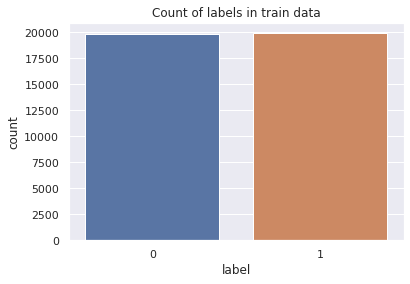

In [17]:
# Countplot to visualize the count of labels
sns.countplot(train_data['label'])
plt.title("Count of labels in train data")
plt.show()

32
13704


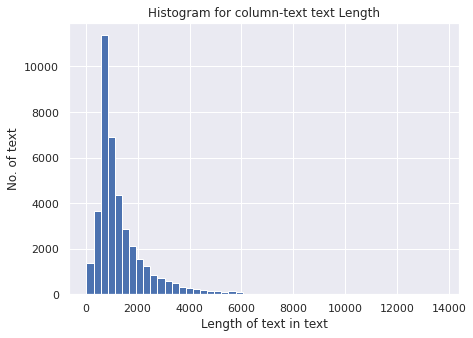

In [18]:
# Histogram for column-text text Length:

sns.set(rc = {'figure.figsize' : (7, 5)})
train_data["text"].str.len().hist(bins = 50)
print(min(train_data["text"].str.len()))
print(max(train_data["text"].str.len()))
plt.title("Histogram for column-text text Length")
plt.xlabel("Length of text in text")
plt.ylabel("No. of text")
plt.show()

# Data preprocessing
  - Detect of data language
  - Divide data into X and y
  - Preprocessing - Remove html tags, unneccessary characters and white spaces, convert into lower case

In [82]:
# Detecting the language for all input texts:

lang_list = []
for i in range(0, train_data.shape[0]):
    try:
        if (train_data["text"][i].strip() != ""):
            lang = detect(train_data["text"][i])
            lang_list.append(lang)
    except:
        continue
        
print("Detected language of input text - ", set(lang_list))

Detected language of input text -  {'en'}


- All the text in train data is in English language.


In [77]:
# Copy of tarin data
train_data_copy = train_data.copy()

In [78]:
# Print a text sample
train_data['text'][1]

"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The actual drawings isnt that bad, 

In [79]:
# Function for spliting the data and preprocessing the text
def data_split(df):
    # Split the data into X and y
    X = df["text"]
    y = df["label"]
    return X, y

def text_preprocessing(df):
    # Removing html tags:
    df = df.apply(lambda x: BeautifulSoup(x, "lxml").text)

    # Selecting only alphabets:
    df = df.apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))

    # Making all textual data lowercase:
    df = df.apply(lambda x: x.lower())

    # Removing all extra white spaces:
    df = df.apply(lambda x: x.strip())
    X = df
    return X

X_train, y_train= data_split(train_data)
X_train = text_preprocessing(X_train)
# Print a text sample after text preprocessing
X_train[1]

'when i put this movie in my dvd player and sat down with a coke and some chips i had some expectations i was hoping that this movie would contain some of the strong points of the first movie awsome animation good flowing story excellent voice cast funny comedy and a kick ass soundtrack but to my disappointment not any of this is to be found in atlantis milo s return had i read some reviews first i might not have been so let down the following paragraph will be directed to those who have seen the first movie and who enjoyed it primarily for the points mentioned when the first scene appears your in for a shock if you just picked atlantis milo s return from the display case at your local videoshop or whatever and had the expectations i had the music feels as a bad imitation of the first movie and the voice cast has been replaced by a not so fitting one with the exception of a few characters like the voice of sweet the actual drawings isnt that bad but the animation in particular is a sad

# Word cloud for train data

In [23]:
# Get a word cloud
t_text = " ".join(t.split()[0] for t in X_train)
print(len(t_text))
word_cloud_t = WordCloud(collocations = False, background_color = 'white').generate(t_text)
t_text

181623


'i when why even im a finally i it my i if i greg a if i the the a ever i i i sweet first the i the it i during how first in three well a sucks superman doll doesn in i three i have the this the when where i i i the i i this the i the okay only thanks vhs first airport when kennan though i i i picking i the with i who as the dragon child i debbie when everything while my the along all i don i released war what dick in if i i some the for after i i i i though this as i 1 there first even so watching the like caught there a i embarassing notable this the one this yes despite caroline the black this honestly critters i just this after by better my if nothing ernest it i when i this what let my i here this i the as this a bruce i if i what about there a this as another this i i i this version there this the red blade i s this checking i i this this the ken i the go monster though i i i the a anne closet omen the australia i i this i i modern alfred this this after the i the now caught afte

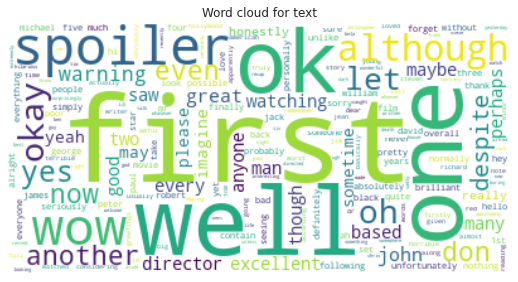

In [24]:
# Plotting the WordCloud image:

plt.imshow(word_cloud_t, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word cloud for text")
plt.show()

- Mostly occurring words in review text are first, well, one, excellent, good, ok, another, good, yeah, spoiler, warning, etc

Max words -  2498
Min words -  6


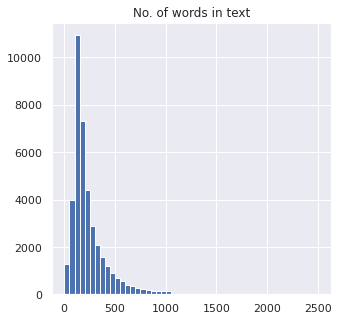

In [25]:
# Looking for max and min words in text:
text_word_count = []

# Populating the lists with sentence lengths:

for i in X_train:
    text_word_count.append(len(i.split()))
print("Max words - ", max(text_word_count))
print("Min words - ", min(text_word_count))
length_df = pd.DataFrame({'text':text_word_count})
sns.set(rc = {'figure.figsize' : (5, 5)})
length_df.hist(bins = 50)
plt.title('No. of words in text')
plt.show()

Maximum char in text -  30
Minimum char in text -  13334


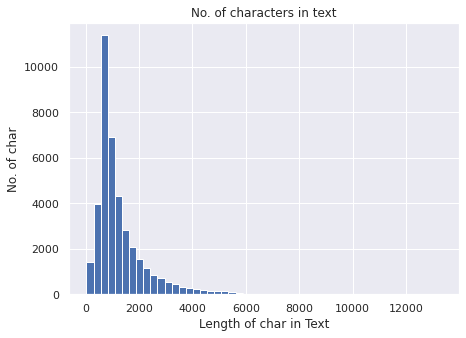

In [26]:
# Looking for max and min characters in text:

sns.set(rc = {'figure.figsize' : (7, 5)})
X_train.str.len().hist(bins = 50)
print("Maximum char in text - ", min(X_train.str.len()))
print("Minimum char in text - ", max(X_train.str.len()))
plt.title("No. of characters in text")
plt.xlabel("Length of char in Text")
plt.ylabel("No. of char")
plt.show()

# Functions to get corpus, TFIDF vectorization and calculate model performance

In [27]:
# Function to get corpus of X data
def get_corpus(X):
  corpus = []
  ps = PorterStemmer()
  for i in range(len(X)):
      text = X[i]
      text = text.split()
      text = [ps.stem(word) for word in text]
      # text = [ps.stem(word) for word in text if word not in set(stopwords.words("english"))]
      text = " ".join(text)
      corpus.append(text)
  print(len(corpus))
  return corpus

# Function to get TFIDF vectoorization
def tfidf_vectorizer(corpus):
  tfidf = TfidfVectorizer(max_features=1000)
  # tfidf = TfidfVectorizer(max_features=2000)
  X_tfidf = tfidf.fit_transform(corpus).toarray()
  print("After tfidf vectorization - Shape of X : ", X_tfidf.shape)
  return X_tfidf, tfidf

# Function to calculate model performance
def calculate_perforormance(y_test , y_test_pred):
    print("Accuracy : data - ", accuracy_score(y_test , y_test_pred))
    print()
    print("Confusion matrix - ")
    print(confusion_matrix(y_test , y_test_pred))
    print()
    print("Classification report - ")
    print(classification_report(y_test , y_test_pred))

In [28]:
# Train data
# Call function to get train data corpus
corpus_train = get_corpus(X_train)

# Call function for TFIDF vectorization
X_train_tfidf, tfidf = tfidf_vectorizer(corpus_train)
print("Shape of y : ", y_train.shape)

# Save tfidf vectorization
pickle.dump(tfidf , open(tfidf_file_path , "wb"))

39723
After tfidf vectorization - Shape of X :  (39723, 1000)
Shape of y :  (39723,)


In [29]:
# Valid data
# Preprocessing of data
X_valid, y_valid= data_split(valid_data)
X_valid = text_preprocessing(X_valid)

# Get corpus of data
corpus_valid = get_corpus(X_valid)

# Vectorization of data
X_valid_tfidf, tfidf = tfidf_vectorizer(corpus_valid)
print("Shape of y : ", y_valid.shape)

5000
After tfidf vectorization - Shape of X :  (5000, 1000)
Shape of y :  (5000,)


In [30]:
# Test data
# Preprocessing on test data
X_test, y_test= data_split(test_data)
X_train = text_preprocessing(X_test)

# Get corpus of data
corpus_test = get_corpus(X_test)

# Vectorization of data
X_test_tfidf, tfidf = tfidf_vectorizer(corpus_test)
print("Shape of y : ", y_test.shape)

5000
After tfidf vectorization - Shape of X :  (5000, 1000)
Shape of y :  (5000,)


# Model - 1 - Multinomial Naive Bayes

In [31]:
# Create Multinomial Naive Bayes model
mnb = MultinomialNB()
mnb.fit(X_train_tfidf , y_train)

MultinomialNB()

In [32]:
# Save the Multinomial Naive Bayes model
pickle.dump(mnb, open(model_mnb_file_path, "wb"))

In [33]:
# Prediction for train data
pred_train = mnb.predict(X_train_tfidf)
print("Accuracy - train data - ", accuracy_score(y_train , pred_train))

Accuracy - train data -  0.8391360169171512


In [34]:
# Test the model on validation data

# Prediction for validation data
pred_valid = mnb.predict(X_valid_tfidf)

# Print accuracy, confusion matrix, classification report
calculate_perforormance(y_valid , pred_valid)

Accuracy : data -  0.5816

Confusion matrix - 
[[1003 1483]
 [ 609 1905]]

Classification report - 
              precision    recall  f1-score   support

           0       0.62      0.40      0.49      2486
           1       0.56      0.76      0.65      2514

    accuracy                           0.58      5000
   macro avg       0.59      0.58      0.57      5000
weighted avg       0.59      0.58      0.57      5000



In [35]:
# Test the model on test data

# Prediction for test data
pred_test = mnb.predict(X_test_tfidf)

# Print accuracy, confusion matrix, classification report
calculate_perforormance(y_test , pred_test)

Accuracy : data -  0.5472

Confusion matrix - 
[[1509  986]
 [1278 1227]]

Classification report - 
              precision    recall  f1-score   support

           0       0.54      0.60      0.57      2495
           1       0.55      0.49      0.52      2505

    accuracy                           0.55      5000
   macro avg       0.55      0.55      0.55      5000
weighted avg       0.55      0.55      0.55      5000



In [36]:
# Load pickeled model
pickled_model = pickle.load(open(model_mnb_file_path,'rb'))
pickled_model.predict(X_test_tfidf)

array([0, 1, 1, ..., 1, 0, 1])

# Model - 2 - Logistic Regression

In [37]:
lr_classifier = LogisticRegression(solver = 'lbfgs')
lr_classifier.fit(X_train_tfidf , y_train)

LogisticRegression()

In [38]:
# Prediction for train data
pred_train_lr = lr_classifier.predict(X_train_tfidf)
print("Accuracy - train data - ", accuracy_score(y_train , pred_train_lr))

Accuracy - train data -  0.8792387281927347


In [39]:
# Prediction for validation data
pred_valid_lr = lr_classifier.predict(X_valid_tfidf)

# Print accuracy, confusion matrix, classification report
calculate_perforormance(y_valid , pred_valid_lr)

Accuracy : data -  0.6032

Confusion matrix - 
[[1389 1097]
 [ 887 1627]]

Classification report - 
              precision    recall  f1-score   support

           0       0.61      0.56      0.58      2486
           1       0.60      0.65      0.62      2514

    accuracy                           0.60      5000
   macro avg       0.60      0.60      0.60      5000
weighted avg       0.60      0.60      0.60      5000



In [40]:
# Prediction for test data
pred_test_lr = lr_classifier.predict(X_test_tfidf)

# Print accuracy, confusion matrix, classification report
calculate_perforormance(y_test , pred_test_lr)

Accuracy : data -  0.5622

Confusion matrix - 
[[1885  610]
 [1579  926]]

Classification report - 
              precision    recall  f1-score   support

           0       0.54      0.76      0.63      2495
           1       0.60      0.37      0.46      2505

    accuracy                           0.56      5000
   macro avg       0.57      0.56      0.55      5000
weighted avg       0.57      0.56      0.55      5000



# Model - 3 - XGBoost Classifier

In [41]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train_tfidf , y_train)

XGBClassifier()

In [42]:
# Prediction for train data
pred_train_xgb = xgb_classifier.predict(X_train_tfidf)
print("Accuracy - train data - ", accuracy_score(y_train , pred_train_xgb))

Accuracy - train data -  0.8270775117690004


In [43]:
# Prediction for validation data
pred_valid_xgb = xgb_classifier.predict(X_valid_tfidf)

# Prediction for validation data
calculate_perforormance(y_valid , pred_valid_xgb)

Accuracy : data -  0.642

Confusion matrix - 
[[1236 1250]
 [ 540 1974]]

Classification report - 
              precision    recall  f1-score   support

           0       0.70      0.50      0.58      2486
           1       0.61      0.79      0.69      2514

    accuracy                           0.64      5000
   macro avg       0.65      0.64      0.63      5000
weighted avg       0.65      0.64      0.63      5000



In [44]:
# Prediction for test data
pred_test_xgb = xgb_classifier.predict(X_test_tfidf)

# Print accuracy, confusion matrix, classification report
calculate_perforormance(y_test , pred_test_xgb)

Accuracy : data -  0.5728

Confusion matrix - 
[[1519  976]
 [1160 1345]]

Classification report - 
              precision    recall  f1-score   support

           0       0.57      0.61      0.59      2495
           1       0.58      0.54      0.56      2505

    accuracy                           0.57      5000
   macro avg       0.57      0.57      0.57      5000
weighted avg       0.57      0.57      0.57      5000



# Model - 4 - DecisionTreeClassifier

In [45]:
dTree_classifier = DecisionTreeClassifier()
dTree_classifier.fit(X_train_tfidf , y_train)

DecisionTreeClassifier()

In [46]:
# Prediction for train data
pred_train_dTree = dTree_classifier.predict(X_train_tfidf)
print("Accuracy - train data - ", accuracy_score(y_train , pred_train_dTree))

Accuracy - train data -  1.0


In [47]:
# Prediction for validation data
pred_valid_dTree = dTree_classifier.predict(X_valid_tfidf)

# Print accuracy, confusion matrix, classification report
print(classification_report(y_valid , pred_valid_dTree))
calculate_perforormance(y_valid , pred_valid_dTree)

              precision    recall  f1-score   support

           0       0.56      0.48      0.52      2486
           1       0.55      0.63      0.59      2514

    accuracy                           0.56      5000
   macro avg       0.56      0.55      0.55      5000
weighted avg       0.56      0.56      0.55      5000

Accuracy : data -  0.5554

Confusion matrix - 
[[1184 1302]
 [ 921 1593]]

Classification report - 
              precision    recall  f1-score   support

           0       0.56      0.48      0.52      2486
           1       0.55      0.63      0.59      2514

    accuracy                           0.56      5000
   macro avg       0.56      0.55      0.55      5000
weighted avg       0.56      0.56      0.55      5000



In [48]:
# Prediction for test data
pred_test_dTree = dTree_classifier.predict(X_test_tfidf)

# Print accuracy, confusion matrix, classification report
calculate_perforormance(y_test , pred_test_dTree)

Accuracy : data -  0.5052

Confusion matrix - 
[[1550  945]
 [1529  976]]

Classification report - 
              precision    recall  f1-score   support

           0       0.50      0.62      0.56      2495
           1       0.51      0.39      0.44      2505

    accuracy                           0.51      5000
   macro avg       0.51      0.51      0.50      5000
weighted avg       0.51      0.51      0.50      5000



# Model 5 - SVM Classifier

In [49]:
svc_classifier = SVC()
svc_classifier.fit(X_train_tfidf , y_train)

SVC()

In [50]:
# Prediction for train data
pred_train_svc = svc_classifier.predict(X_train_tfidf)
print("Accuracy - train data - ", accuracy_score(y_train , pred_train_svc))

Accuracy - train data -  0.9523953377136671


In [51]:
# Prediction for validation data
pred_valid_svc = svc_classifier.predict(X_valid_tfidf)

# Print accuracy, confusion matrix, classification report
calculate_perforormance(y_valid , pred_valid_svc)

Accuracy : data -  0.602

Confusion matrix - 
[[1311 1175]
 [ 815 1699]]

Classification report - 
              precision    recall  f1-score   support

           0       0.62      0.53      0.57      2486
           1       0.59      0.68      0.63      2514

    accuracy                           0.60      5000
   macro avg       0.60      0.60      0.60      5000
weighted avg       0.60      0.60      0.60      5000



In [54]:
# Prediction for test data
pred_test_svc = svc_classifier.predict(X_test_tfidf)

# Print accuracy, confusion matrix, classification report
calculate_perforormance(y_test , pred_test_svc)

Accuracy : data -  0.5598

Confusion matrix - 
[[1802  693]
 [1508  997]]

Classification report - 
              precision    recall  f1-score   support

           0       0.54      0.72      0.62      2495
           1       0.59      0.40      0.48      2505

    accuracy                           0.56      5000
   macro avg       0.57      0.56      0.55      5000
weighted avg       0.57      0.56      0.55      5000



# Hyperparameter tuning for Model - 3 xgb_classifier 

In [59]:
# Parameter grid for XGBoost
def grid_xgb(X, y):
    X = X.astype(float)
    y = y.astype(int)
    params = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
            }
    xgb_classifier_rscv = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                        silent=True, nthread=1)
    folds = 3
    param_comb = 5
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
    random_search = RandomizedSearchCV(xgb_classifier_rscv, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001 )
    random_search.fit(X, y)
    print('\n All results -> ', random_search.cv_results_)
    print('\n Best estimator:')
    print('\n Best estimator -> ', random_search.best_estimator_)
    print('\n Best normalized gini score for %d-fold search with %d parameter combinations -> ' % (folds, param_comb))
    print(random_search.best_score_ * 2 - 1)
    print('\n Best hyperparameters -> ', random_search.best_params_)
grid_xgb(X_train_tfidf , y_train)

-  Best hyperparameters ->  {'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 1.5, 'colsample_bytree': 0.8}

In [56]:
xgb_classifier_hp = xgb. XGBClassifier(colsample_bytree=0.8, gamma=1.5, learning_rate=0.02, max_depth=5, n_estimators=600, nthread=1, silent=True, subsample=0.6)
xgb_classifier_hp.fit(X_train_tfidf , y_train)

XGBClassifier(colsample_bytree=0.8, gamma=1.5, learning_rate=0.02, max_depth=5,
              n_estimators=600, nthread=1, silent=True, subsample=0.6)

In [57]:
# Prediction for train data
pred_train_xgb_hp = xgb_classifier_hp.predict(X_train_tfidf)
print("Accuracy - train data - ", accuracy_score(y_train , pred_train_xgb_hp))

Accuracy - train data -  0.8748080457165873


In [58]:
# Prediction for validation data
pred_valid_xgb_hp = xgb_classifier_hp.predict(X_valid_tfidf)

# Prediction for validation data
calculate_perforormance(y_valid , pred_valid_xgb_hp)

Accuracy : data -  0.637

Confusion matrix - 
[[1174 1312]
 [ 503 2011]]

Classification report - 
              precision    recall  f1-score   support

           0       0.70      0.47      0.56      2486
           1       0.61      0.80      0.69      2514

    accuracy                           0.64      5000
   macro avg       0.65      0.64      0.63      5000
weighted avg       0.65      0.64      0.63      5000



In [59]:
# Prediction for test data
pred_test_xgb_hp = xgb_classifier_hp.predict(X_test_tfidf)

# Print accuracy, confusion matrix, classification report
calculate_perforormance(y_test , pred_test_xgb_hp)

Accuracy : data -  0.5734

Confusion matrix - 
[[1711  784]
 [1349 1156]]

Classification report - 
              precision    recall  f1-score   support

           0       0.56      0.69      0.62      2495
           1       0.60      0.46      0.52      2505

    accuracy                           0.57      5000
   macro avg       0.58      0.57      0.57      5000
weighted avg       0.58      0.57      0.57      5000



#### With basic XGBoost classifier, getting the accuracy on - 
- Train set -> 82.9%,
- Valid Set -> 53.9%
- Test set -> 54.8%.

#### After hyper paramter tuning, XGBoost classifier goving the accuracy on - 
- Train set -> 87.4%,
- Valid Set -> 63.7%
- Test set -> 57.34%

#### Accuracy increased after hyper parameter tuning.


In [60]:
# Save the XGBoost classifier model with best hyperparameters
pickle.dump(xgb_classifier_hp, open(model_xgbhp_file_path, "wb"))

# CountVectorization

In [61]:
# define count vectorizer
count_vect = CountVectorizer(ngram_range=(1,2))

# CV - Model 1 - MultinomialNB

- Train the model on train data

In [62]:
# Get count vectorixer for train data
X_train_cv_unibigram = count_vect.fit_transform(corpus_train)

In [63]:
# Create Multinomial Naive Bayes model
mnb_cv = MultinomialNB()
mnb_cv.fit(X_train_cv_unibigram , y_train)

# Prediction for train data
pred_train_cv_mnb = mnb_cv.predict(X_train_cv_unibigram)
print("Accuracy - train data - ", accuracy_score(y_train , pred_train_cv_mnb))

Accuracy - train data -  0.9825793620824208


- Test the model on valid data

In [64]:
# Vectorization of data
X_valid_cv_unibigram = count_vect.transform(corpus_valid)

# Prediction for validation data
pred_valid_cv_mnb = mnb_cv.predict(X_valid_cv_unibigram)

# Print accuracy, confusion matrix, classification report
calculate_perforormance(y_valid , pred_valid_cv_mnb)

Accuracy : data -  0.8734

Confusion matrix - 
[[2206  280]
 [ 353 2161]]

Classification report - 
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      2486
           1       0.89      0.86      0.87      2514

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



In [65]:
valid_pred_df = pd.DataFrame(np.c_[y_valid , pred_valid_cv_mnb] , columns=["Actual" , "Predicted"])
valid_pred_df.to_csv(project_folder_path + "valid_pred_df.csv")

- Test the model on test data

In [66]:
# Vectorization of data
X_test_cv_unibigram = count_vect.transform(corpus_test)

# Test the model on test data

# Prediction for validation data
pred_test_cv_mnb = mnb_cv.predict(X_test_cv_unibigram)
print(pred_test_cv_mnb)
# Print accuracy, confusion matrix, classification report
calculate_perforormance(y_test , pred_test_cv_mnb)

[0 0 0 ... 0 0 0]
Accuracy : data -  0.8854

Confusion matrix - 
[[2190  305]
 [ 268 2237]]

Classification report - 
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2495
           1       0.88      0.89      0.89      2505

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [67]:
print(X_train_cv_unibigram.shape, X_valid_cv_unibigram.shape, X_test_cv_unibigram.shape)
# print(vectors.shape, vectors_test.shape)

(39723, 1793787) (5000, 1793787) (5000, 1793787)


# CV - Model 2 - XGBoost Classifier

In [68]:
xgb_classifier_cv = xgb.XGBClassifier()
xgb_classifier_cv.fit(X_train_cv_unibigram , y_train)

# Prediction for train data
pred_train_xgb_cv = xgb_classifier_cv.predict(X_train_cv_unibigram)
print("Accuracy - train data - ", accuracy_score(y_train , pred_train_xgb_cv))

Accuracy - train data -  0.8287138433653047


In [69]:
# Prediction for validation data
pred_valid_xgb_cv = xgb_classifier_cv.predict(X_valid_cv_unibigram)

# Prediction for validation data
calculate_perforormance(y_valid , pred_valid_xgb_cv)

Accuracy : data -  0.8164

Confusion matrix - 
[[1862  624]
 [ 294 2220]]

Classification report - 
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      2486
           1       0.78      0.88      0.83      2514

    accuracy                           0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000



In [70]:
# Prediction for test data
pred_test_xgb_cv = xgb_classifier_cv.predict(X_test_cv_unibigram)

# Print accuracy, confusion matrix, classification report
calculate_perforormance(y_test , pred_test_xgb_cv)

Accuracy : data -  0.8094

Confusion matrix - 
[[1838  657]
 [ 296 2209]]

Classification report - 
              precision    recall  f1-score   support

           0       0.86      0.74      0.79      2495
           1       0.77      0.88      0.82      2505

    accuracy                           0.81      5000
   macro avg       0.82      0.81      0.81      5000
weighted avg       0.82      0.81      0.81      5000





#### With CountVectorizer and  Multinomial Naive Bayes, getting the accuracy on - 
- Train set -> 98.25%,
- Valid Set -> 87.34%
- Test set -> 88.54%.

#### With CountVectorizer and  XGBoost classifier, getting the accuracy on -  
- Train set -> 82.87%,
- Valid Set -> 81.6%
- Test set -> 80.94%

# CountVectorizer vectors with Multinomial Naive Bayes is giving the highest accuracy on train, valid and test data.


In [71]:
# Save count vectorizer
pickle.dump(count_vect , open(cv_file_path , "wb"))

# Save the Multinomial Naive Bayes model
pickle.dump(mnb_cv, open(model_mnb_cv_file_path, "wb"))

In [72]:
pickled_model_cv = pickle.load(open(cv_file_path,'rb'))
pickled_model_mnb_cv = pickle.load(open(model_mnb_cv_file_path,'rb'))

In [73]:
sentence = "It was a good movie."
sen_cv = pickled_model_cv.transform([sentence]).toarray()
sentiment = pickled_model_mnb_cv.predict(sen_cv)[0]
if sentiment == 1 :
  response = "positive"
else:
  response = "negative"
print("Sentense - %s and it is %s."%(sentence, response))

Sentense - It was a good movie. and it is positive.


In [74]:
sentence = "It was a bad movie."
sen_cv = pickled_model_cv.transform([sentence]).toarray()
sentiment = pickled_model_mnb_cv.predict(sen_cv)[0]
if sentiment == 1 :
  response = "positive"
else:
  response = "negative"
print("Sentense - %s and it is %s."%(sentence, response))

Sentense - It was a bad movie. and it is negative.


# First page for sentiment analysis of review :

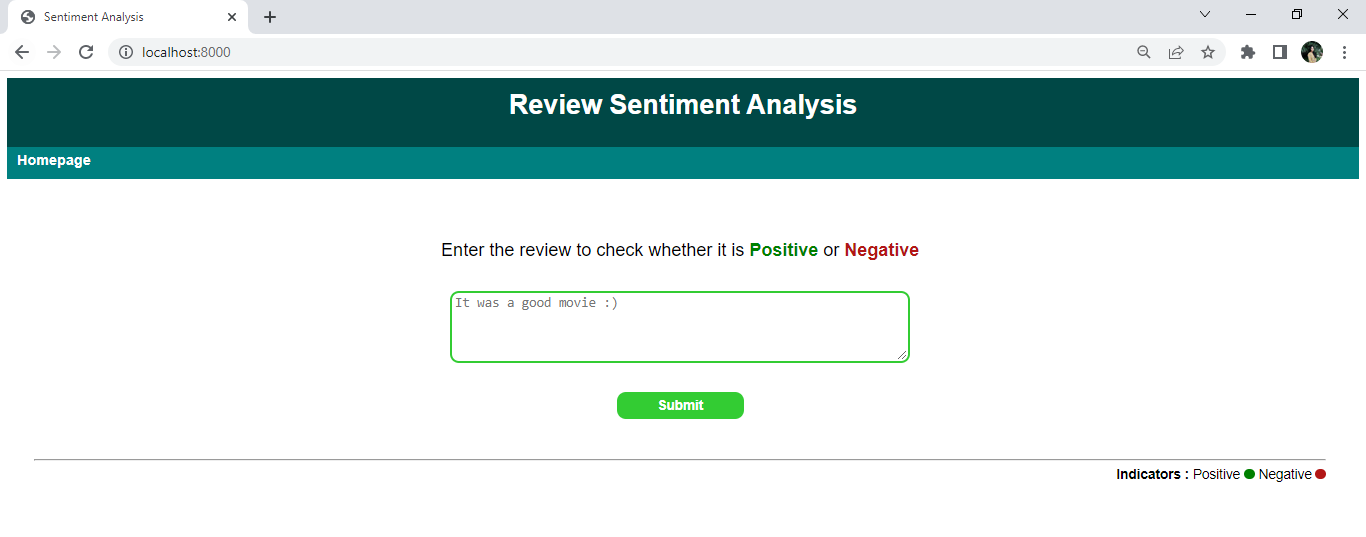

- Enter the review in textbox to check whether it is positive or negative.

- If enter text is "It was a good movie!!!" or positive review, it will navigate to below page.
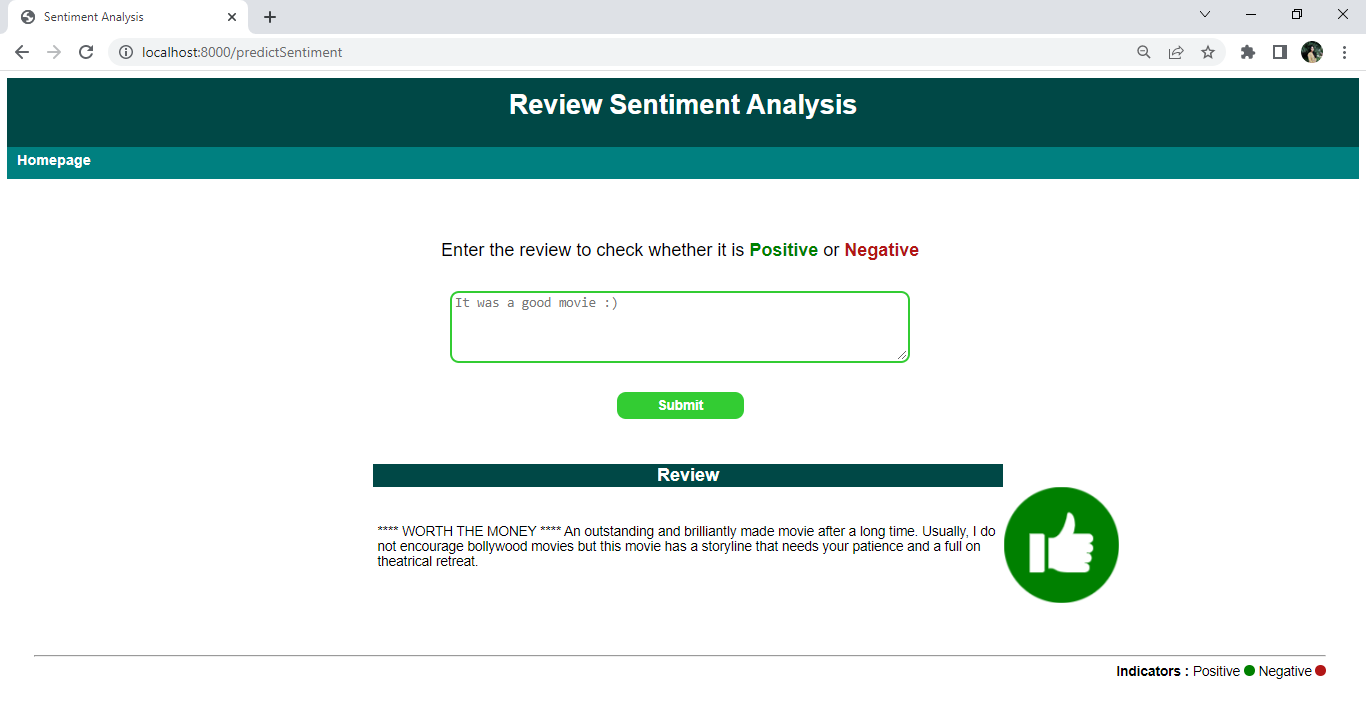


- If enter text is "It was a bad movie!!!" or negative review, it will navigate to below page.
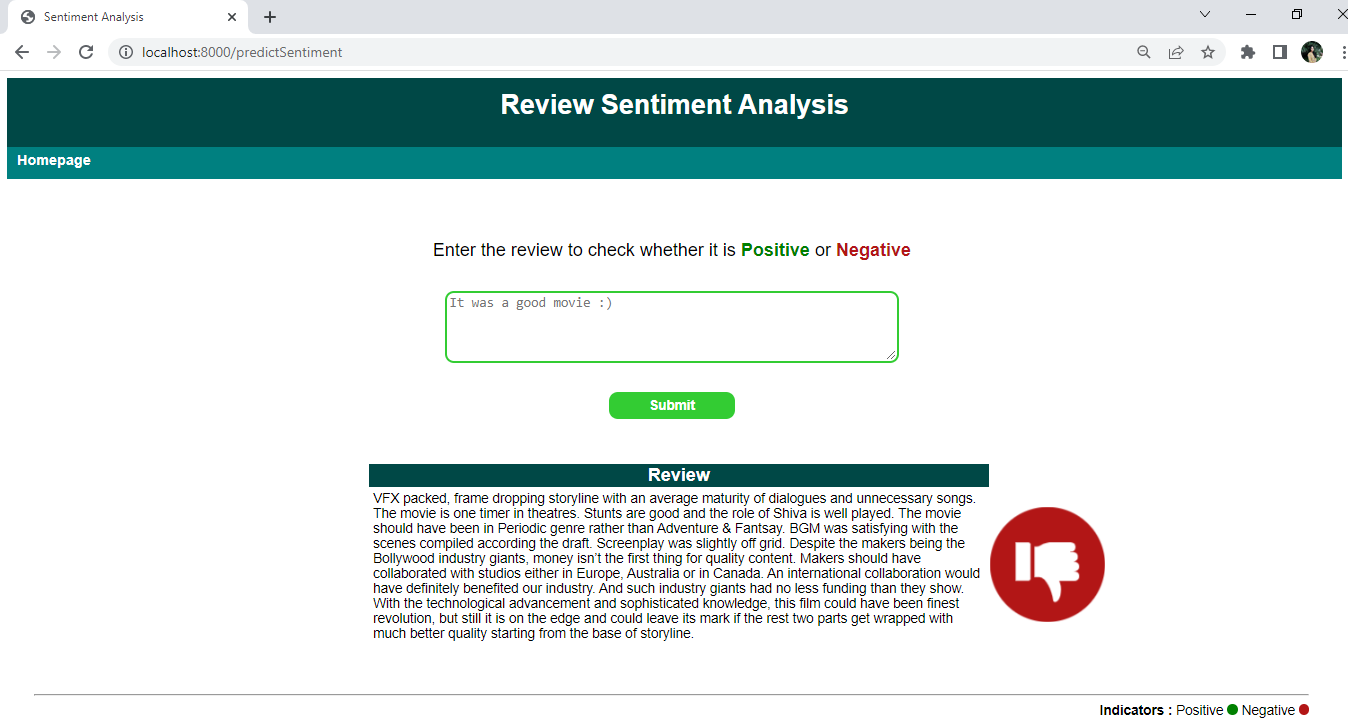

**Thank You!!!**

**Happy Learning :)**

---



